Dataset loaded. Shape: (891, 12)

Column info and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch      

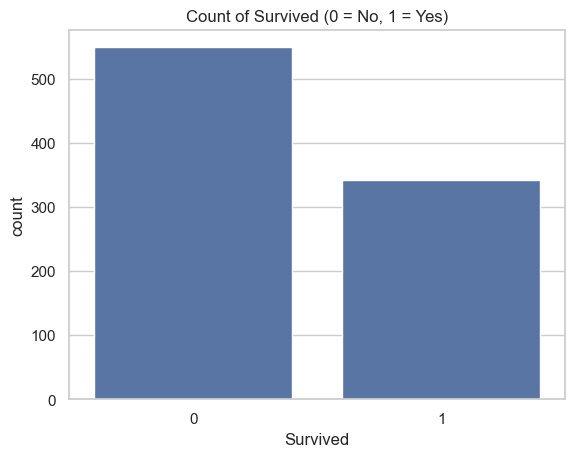

Remaining columns: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Title values: ['Mr' 'Mrs' 'Miss' 'Master' 'Rare' 'the Countess']
Missing values after basic fill:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64
Columns after encoding: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess']
Feature matrix shape: (891, 18)
Train size: (712, 18) Validation size: (179, 18)
Validation Accuracy: 0.8212

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81   

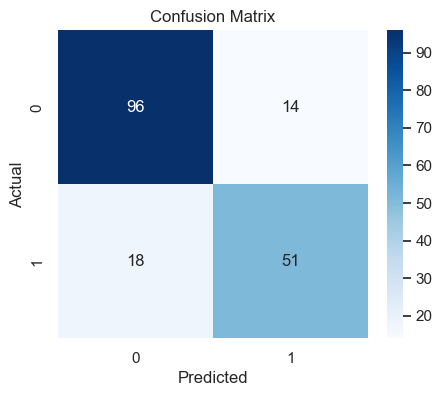

Top features:
       feature  importance
4         Fare    0.237868
1          Age    0.205819
7   Sex_female    0.099460
8     Sex_male    0.093481
14    Title_Mr    0.086016
0       Pclass    0.077972
5   FamilySize    0.046864
2        SibSp    0.030290
3        Parch    0.021240
13  Title_Miss    0.020307


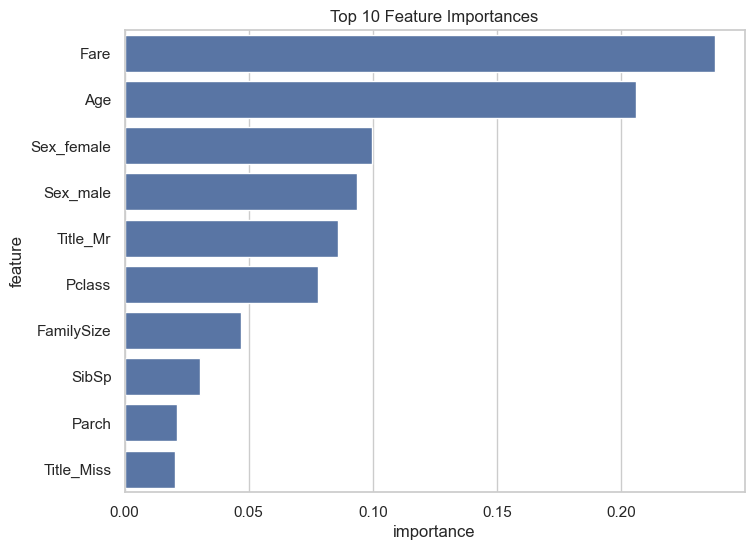

Validation ROC AUC: 0.8272


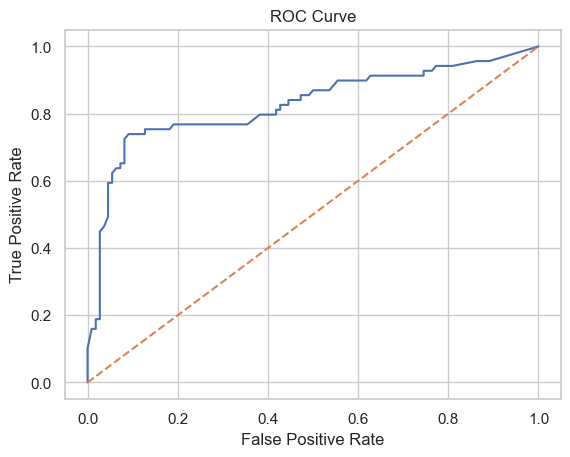

Model saved to C:\Users\RAKSHITH\CodeSoft Internship\task 1\titanic_rf_model.pkl
Scaler saved to C:\Users\RAKSHITH\CodeSoft Internship\task 1\titanic_scaler.pkl
Sample predictions (first 5 validation rows): [0 0 0 0 1]
Actual values: [0 0 1 0 1]
Notebook complete. Review cells, run them top-to-bottom, and modify as needed.


In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve)
import pickle

sns.set(style='whitegrid')

# %%
path = 'Titanic-Dataset.csv'
data = pd.read_csv(path)
print("Dataset loaded. Shape:", data.shape)
data.head()

# %%
print("\nColumn info and non-null counts:")
print(data.info())
print("\nMissing values per column:")
print(data.isnull().sum())
missing_pct = (data.isnull().sum() / len(data)) * 100
pd.DataFrame({'missing_count': data.isnull().sum(), 'missing_pct': missing_pct}).sort_values('missing_pct', ascending=False)

# %%
data.describe()

# %%
if 'Survived' in data.columns:
    sns.countplot(x='Survived', data=data)
    plt.title('Count of Survived (0 = No, 1 = Yes)')
    plt.show()
else:
    print("No 'Survived' column found.")

# %%
df = data.copy()
for col in ['PassengerId', 'Ticket', 'Cabin']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)
print('Remaining columns:', df.columns.tolist())

# %%
if 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
    df.drop(columns='Name', inplace=True)
    print('Title values:', df['Title'].unique())
else:
    print('Name column not found')

# %%
if 'Age' in df.columns:
    df['Age'] = df['Age'].fillna(df['Age'].median())
if 'Embarked' in df.columns:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
if 'Fare' in df.columns and df['Fare'].isnull().sum() > 0:
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
print('Missing values after basic fill:')
print(df.isnull().sum())

# %%
if set(['SibSp','Parch']).issubset(df.columns):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# %%
cat_cols = []
if 'Sex' in df.columns:
    cat_cols.append('Sex')
if 'Embarked' in df.columns:
    cat_cols.append('Embarked')
if 'Title' in df.columns:
    cat_cols.append('Title')

df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print('Columns after encoding:', df.columns.tolist())

# %%
if 'Survived' not in df.columns:
    raise ValueError("'Survived' column not found.")

X = df.drop(columns='Survived')
Y = df['Survived']
print('Feature matrix shape:', X.shape)

# %%
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print('Train size:', X_train.shape, 'Validation size:', X_val.shape)

# %%
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])

# %%
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# %%
y_pred = rf.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print('\nClassification Report:')
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# %%
importances = rf.feature_importances_
feat_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)
print('Top features:')
print(feat_df.head(10))
plt.figure(figsize=(8,6))
sns.barplot(data=feat_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.show()

# %%
if hasattr(rf, 'predict_proba'):
    y_proba = rf.predict_proba(X_val_scaled)[:,1]
    auc = roc_auc_score(y_val, y_proba)
    print(f'Validation ROC AUC: {auc:.4f}')
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# %%
import os
import pickle 
save_dir = r"C:\Users\RAKSHITH\CodeSoft Internship\task 1"
model_filename = os.path.join(save_dir, 'titanic_rf_model.pkl')
scaler_filename = os.path.join(save_dir, 'titanic_scaler.pkl')

with open(model_filename, 'wb') as f:
    pickle.dump(rf, f)
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)

print(f'Model saved to {model_filename}')
print(f'Scaler saved to {scaler_filename}')

# %%
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)
with open(scaler_filename, 'rb') as f:
    loaded_scaler = pickle.load(f)

sample_X = X_val.copy().iloc[:5]
sample_X[numeric_cols] = loaded_scaler.transform(sample_X[numeric_cols])
sample_preds = loaded_model.predict(sample_X)
print('Sample predictions (first 5 validation rows):', sample_preds)
print('Actual values:', y_val.iloc[:5].values)

# %%
print('Notebook complete.')
